**SPAM DETECTION BY MEHMET ANIL TAYSI**

This notebook was created for the Teknasyon Data Scientist Case (Part A: Spam Detection on Text Data). 

**M. Anıl Taysi**

# 1. DATA ACQUISITION

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [30]:
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [3]:
spam_df = pd.read_csv("datasets/sms_spam_train.csv")

In [4]:
spam_df.head()

,Message,Label
0,Whats upp ac enisteee: -) senin memlekette bul...,ham
1,"Kampanya, VakifBank Worldcardla 31 Mayisa kada...",spam
2,I wont. So wat's wit the guys,ham
3,Bu arada son dakika evi düşürdük,ham
4,No that just means you have a fat head,ham


In [5]:
label_cnt = spam_df.Label.value_counts()

This visualization shows the distribution of spam and ham messages using a pie chart and a bar chart.

The pie chart displays the percentage of spam vs ham messages. (percentile distribution)
The bar chart shows the total count of each label.

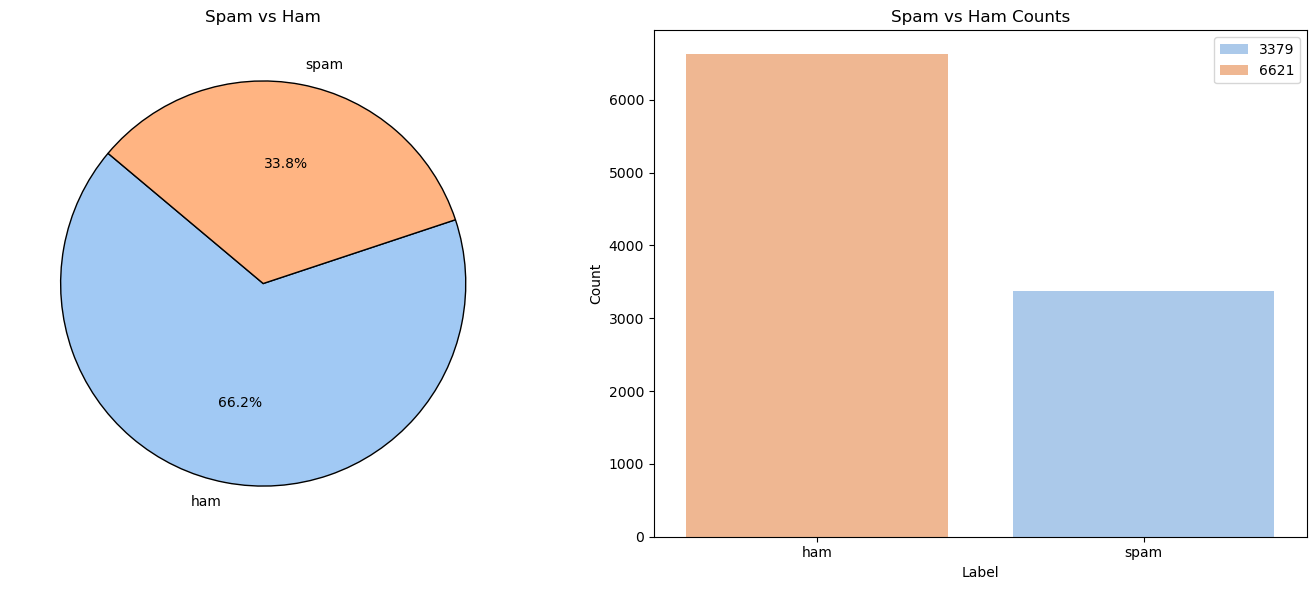

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].pie(label_cnt, labels=label_cnt.index, autopct='%1.1f%%', startangle=140, 
            wedgeprops={'edgecolor': 'black'}, colors=sns.color_palette("pastel"))
axes[0].set_title('Spam vs Ham')

sns.barplot(x=label_cnt.index, y=label_cnt.values, palette="pastel", ax=axes[1], hue=label_cnt.values)
axes[1].set_xlabel('Label')
axes[1].set_ylabel('Count')
axes[1].set_title('Spam vs Ham Counts')

plt.tight_layout()
plt.show()

**Actually, I was expecting a way imbalanced dataset than that. I am going to use class weights to overcome that, it's viable to start with same weights for each class. Also, it's a relatively small dataset. I would like to populate the dataset If I have to create a production level solution.**

In [7]:
spam_df['label'] = spam_df['Label'].apply(lambda x: 1 if x.strip().lower() in ['spam'] else 0)
spam_df['Message'] = spam_df['Message'].astype(str).str.strip()

# 2. LANGUAGE DETECTION & DISTRIBUTION

## 2.1 Language Detection for Preprocessing  

Detecting the **language** of texts in the dataset is crucial for **effective preprocessing**.  

- Each language has its own **stemming** and **normalization** rules.  
- Applying these steps based on the detected language ensures **better text processing**.  

###  **Current Step:**  
- **Identify** the languages present in the dataset.  
- **Visualize** their distribution to understand language diversity.  

In [8]:
from collections import Counter
from langdetect import detect, DetectorFactory

import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
def detect_language(text):
    try:
        detected_lang = detect(text)
    except Exception as e:
        detected_lang = 'en'
    
    return detected_lang

spam_df["Language"] = spam_df["Message"].apply(detect_language)

spam_lang_counts = Counter(spam_df[spam_df["Label"] == "spam"]["Language"])
ham_lang_counts = Counter(spam_df[spam_df["Label"] == "ham"]["Language"])

spam_lang_df = pd.DataFrame(spam_lang_counts.items(), columns=["Language", "Spam Count"])
ham_lang_df = pd.DataFrame(ham_lang_counts.items(), columns=["Language", "Ham Count"])

lang_distribution_df = pd.merge(spam_lang_df, ham_lang_df, on="Language", how="outer").fillna(0)




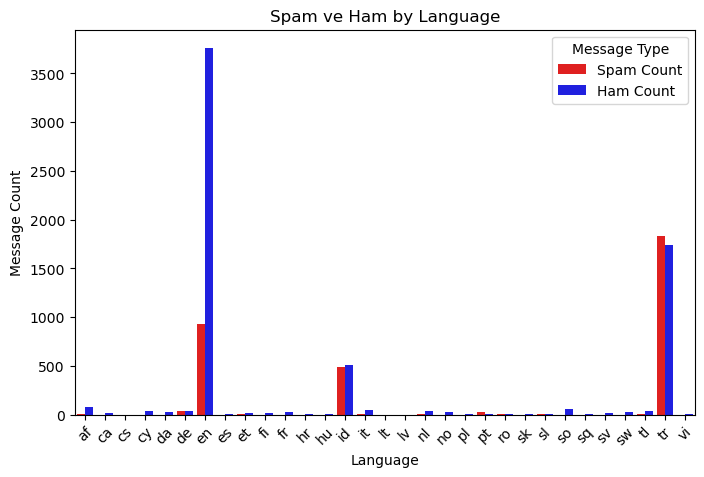

In [10]:
plt.figure(figsize=(8, 5))
sns.barplot(data=lang_distribution_df.melt(id_vars="Language", var_name="Message Type", value_name="Count"),
            x="Language", y="Count", hue="Message Type", palette=["red", "blue"])
plt.xlabel("Language")
plt.ylabel("Message Count")
plt.title("Spam ve Ham by Language")
plt.xticks(rotation=45)
plt.legend(title="Message Type")
plt.show()

**We can clearly see that there is no imbalance in Turkish, however we can't say the same for English. Valuable info to consider.**

Message length is a significant feature in spam detection. Spam messages often have different length patterns compared to ham (non-spam) messages.

The box plot below visualizes the distribution of message lengths for spam and ham messages. This helps us understand:

How message length varies between spam and ham.
If spam messages tend to be shorter or longer.
The presence of outliers in message length.
By analyzing this, we can gain insights into whether message length is a useful feature for classification.

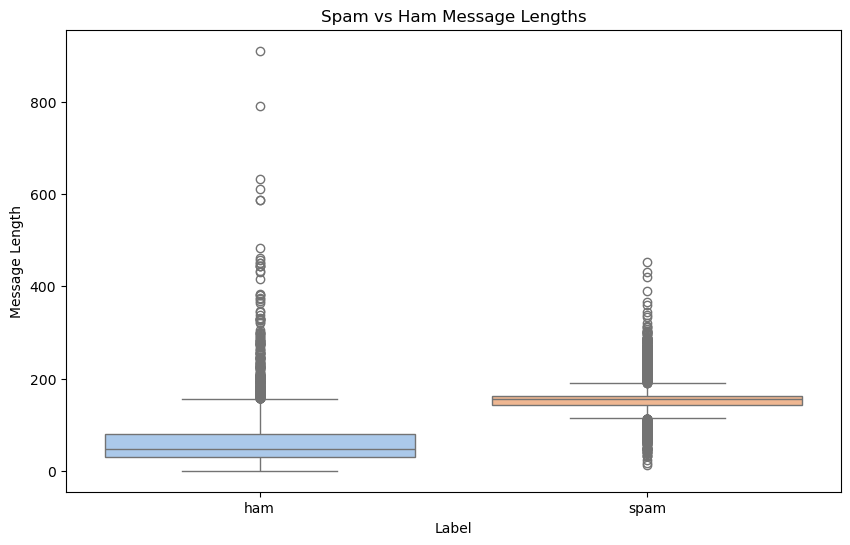

In [11]:
spam_df["Message_Length"] = spam_df["Message"].str.len()

plt.figure(figsize=(10, 6))
sns.boxplot(x="Label", y="Message_Length", data=spam_df, palette="pastel", hue="Label")
plt.xlabel("Label")
plt.ylabel("Message Length")
plt.title("Spam vs Ham Message Lengths")
plt.show()

In [12]:
train_df, test_df = train_test_split(
    spam_df, 
    test_size=0.3, 
    random_state=42, 
    stratify=spam_df['label']
)

print("Eğitim seti boyutu:", train_df.shape)
print("Test seti boyutu:", test_df.shape)

Eğitim seti boyutu: (7000, 5)
Test seti boyutu: (3000, 5)


# 3. TF-IDF into SVM Modelling

## Text Classification Pipeline: TF-IDF + SVM  

In this step, we build a **text classification pipeline** using:  

- **TF-IDF (Term Frequency-Inverse Document Frequency)** 
  - Converts text into numerical features by capturing important word patterns.  

- **SVM (Support Vector Machine - Linear SVC)**  
  - A powerful classifier for distinguishing **spam vs. ham** messages.  

### **Evaluation Metrics:**  
- **Classification Report** to assess precision, recall, and F1-score.  
- **Confusion Matrix** to analyze true/false positives and negatives.  

This approach ensures an effective **spam detection model** by leveraging **word importance and a robust classification algorithm**.  


In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix

# TF-IDF ve SVM'yi bir pipeline içinde birleştiriyoruz.
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        lowercase=True,
        ngram_range=(1, 2),
        max_features=10000
    )),
    ('svm', LinearSVC(random_state=42))
])


pipeline.fit(train_df['Message'], train_df['label'])
preds = pipeline.predict(test_df['Message'])

print("TF-IDF + SVM Results")
print(classification_report(test_df['label'], preds, target_names=['Not Spam', 'Spam']))
print(confusion_matrix(test_df['label'], preds))


TF-IDF + SVM Results
              precision    recall  f1-score   support

    Not Spam       0.99      1.00      0.99      1986
        Spam       0.99      0.97      0.98      1014

    accuracy                           0.99      3000
   macro avg       0.99      0.98      0.99      3000
weighted avg       0.99      0.99      0.99      3000

[[1978    8]
 [  29  985]]


## Test with custom Messages

In [64]:
messages = [
    "500 dolar Kazandınız! Hemen linke tıklayın!!!",
    "You won 500 dollars! Just click the link and claim your reward!!!",
    "Merhaba, nasılsın?",
    "Bu çok önemli bir teklif, hemen dönüş yapın.",
    "This is an important offer! please call me back.",
    "Selam, bugün buluşalım mı?",
    "Hi, how are you?",
    "Sifir yazilim bilgisiyle 6 ayda yazilimci olun, sadece 1000 dolar. hemen tıklayın.",
    "Become a software developer in 6 months with zero coding knowledge, only $1000. Click now!"
]

preds = pipeline.predict(messages)
preds

array([0, 1, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

## Enhancing Model Generalization  

Training an **SVM model** with **TF-IDF vectorization** (without preprocessing) yields good results on the **test set**, but struggles with **unseen sentence structures** due to the lack of **deeper contextual embeddings**.  

### **Next Steps for Improvement:**  
✔️ **Apply preprocessing** to enhance text consistency.  
✔️ **Test performance** with **pre-trained language models** and **custom deep learning models** to capture richer semantic relationships.  

By incorporating these improvements, we aim to **enhance generalization** and improve the model’s ability to handle **diverse, real-world text inputs**.  


In [15]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset
import evaluate

In [16]:
accuracy_metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return accuracy_metric.compute(predictions=predictions, references=labels)

## Language Processing & Stemming Approach  

To preprocess text effectively, we implemented **language detection, cleaning, and stemming** techniques:  

### **Steps Taken:**  

✔️ **Language Detection:** Used `langdetect` to identify the language of each text.  
✔️ **Text Cleaning (`clean_text`)**  
   - Removes **URLs, emails, phone numbers, HTML tags**, and excessive punctuation.  
   - **Normalizes repeated characters** (e.g., `"loooove"` → `"loove"`).  
   - Converts text to **lowercase** and removes **special characters**.  

✔️ **Tokenization & Stemming (`stem_text`)**  
   - Uses **NLTK word tokenization** for splitting text into words.  
   - **English Stemming:** `SnowballStemmer` is applied for **root word extraction**.  
   - **Turkish Stemming:** `get_stemmed_tokens()` (Initially tested `TurkishStemmer`, but results were suboptimal).  
   - Planning to implement **SpaCy (`tr_core_news_md`)** for improved **Turkish language processing**.  

These steps help **normalize** and **standardize** text, ensuring **better feature extraction** and **improved classification accuracy** in the model.  


In [61]:
import re
import nltk
from langdetect import detect, DetectorFactory

DetectorFactory.seed = 0

#nltk.download('punkt')
#nltk.download('punkt_tab')

from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer

# from TurkishStemmer import TurkishStemmer
#turkishstemmer kullanıldı. iyi sonuç vermedi, spacy çözümü denenecek
import spacy

##### to use this spacy model, pip install tr_core_news_md-1.0-py3-none-any.whl & I have downloaded it from https://huggingface.co/turkish-nlp-suite/tr_core_news_md
nlp = spacy.load("tr_core_news_md")

In [18]:
def get_stemmed_tokens(sentence):
    doc = nlp(sentence)
    return [token.lemma_ for token in doc]

# spacy Turkish model downloaded (still, there isnt any an official model for Turkish language, unfortunetly)

In [19]:
def normalize_repeated_characters(text):
    return re.sub(r'(.)\1{2,}', r'\1\1', text)

def clean_text(text, language='english'):
    text = re.sub(r'http\S+|www\.\S+', ' ', text)
    text = re.sub(r'\S+@\S+', ' ', text)
    text = re.sub(r'\+?\d[\d\-\(\) ]{7,}\d', ' ', text)
    text = re.sub(r'<.*?>', ' ', text)
    text = normalize_repeated_characters(text)
    text = re.sub(r'([!?.]){2,}', r'\1', text)
    text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    text = text.lower()
    return text

def stem_text(text, language='en'):
    tokens = word_tokenize(text)
    if language.lower() == 'en':
        stemmer = SnowballStemmer("english")
        stemmed_tokens = [stemmer.stem(token) for token in tokens]
    elif language.lower() == 'tr':
        stemmed_tokens = get_stemmed_tokens(text)
    else:
        stemmed_tokens = tokens
    return " ".join(stemmed_tokens)

In [20]:
def advanced_text_processing(df):  
    text = df['text']
    language = df['Language']
    text = text.lower()
    # cleaned = clean_text(text, language=language)
    stemmed = stem_text(text, language=language)
    # print("text:   " + text + "----" + "stemmed:   " + stemmed)
    return stemmed

def text_process_map(df):
    df["text_processed"] = advanced_text_processing(df)
    return df

In [21]:
train_df.columns

Index(['Message', 'Label', 'label', 'Language', 'Message_Length'], dtype='object')

In [22]:
train_dataset = Dataset.from_pandas(train_df[['Message', 'label', 'Language']].rename(columns={'Message': 'text'}))
test_dataset = Dataset.from_pandas(test_df[['Message', 'label', 'Language']].rename(columns={'Message': 'text'}))

In [23]:
train_dataset = train_dataset.map(text_process_map)
test_dataset = test_dataset.map(text_process_map)

Map:   0%|          | 0/7000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

In [24]:
train_dataset

Dataset({
    features: ['text', 'label', 'Language', '__index_level_0__', 'text_processed'],
    num_rows: 7000
})

In [25]:
train_dataset["text_processed"][:10]

["allah'ım ya düşüne : )",
 'i call but no one pick up e phone . i ask both of them alreadi they said ok .',
 'alanya sea bird beach otelimizd 5 gece 6 gun hersey dahil 12 yas ucretsiz sadec 550 tl www.seabirdbeach.com bilgi ve rzv . 02427450301 www.iptalsms.com',
 'nomormu memang yang paling beruntung : tes identitas tersedia untukmu ! menangkan pulsa rp10rb pada tes ke-30 . kirim sms y ke 99455 sekarang ! info:838 vd001',
 'hmv bonus special 500 pound of genuin hmv voucher to be won . just answer 4 easi question . play now ! send hmv to 86688 more info : www.100percent-real.com',
 'yeti̇şen aliyoorrr başladiii .. tri̇ko 3.50 - tri̇ko 9.90 - elbi̇se 9.90 - kaşe kaban 29.90 - şi̇mşe yelek 34.90 tl . bu firsat kaçirmayin , keyi̇fli̇ alişveri̇şler .',
 "that 's cool , i ll come by like & lt ; # & gt ; ish",
 'did you get ani gift ? this year i didnt get anyth . so bad',
 'pt.indofood.tbk menyampaikan bahwa anda telah resmi menangkan uang rp.49jt dari pop mie no.pin xy7qd77 , info lengkap

In [26]:
train_dataset = train_dataset.remove_columns("text")
test_dataset = test_dataset.remove_columns("text")

## Fine-Tuning Pretrained Multilingual Models  

To enhance spam detection, we fine-tune **pretrained transformer models** on our dataset.  

### **Models Used:**  
✔️ **DistilBERT Multilingual** (`distilbert-base-multilingual-cased`)  
✔️ **BERT Multilingual** (`bert-base-multilingual-cased`)  
✔️ **XLM-RoBERTa Base** (`xlm-roberta-base`)  

### **Fine-Tuning Process:**  
1. **Tokenization & Processing**:  
   - Uses `AutoTokenizer` for **text tokenization**.  
   - Applies **padding, truncation, and max_length adjustments**.  

2. **Training & Evaluation**:  
   - **Hugging Face Trainer API** handles model training.  
   - Evaluates performance using **accuracy**, **confusion matrix**, and **classification report**.  

3. **Results Comparison**:  
   - **Stores evaluation metrics** for model comparison.  
   - Helps determine which **pretrained model** performs best for spam detection.  

This approach **leverages transfer learning**, allowing the model to **adapt multilingual knowledge** for spam classification while minimizing data requirements. 🚀  


In [27]:
models = {
    "DistilBERT Multilingual": "distilbert-base-multilingual-cased",
    "BERT Multilingual": "bert-base-multilingual-cased",
    "XLM-RoBERTa Base": "xlm-roberta-base"
}

results = {}

In [28]:
for model_label, model_name in models.items():
    print(f"\n\n==============================")
    print(f"{model_label} model ile eğitim başladı ({model_name})...")
    print(f"==============================\n")
    
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
    
    def tokenize_function(dataset):
        return tokenizer(dataset["text_processed"], padding="max_length", truncation=True, max_length=128)
    
    tokenized_train = train_dataset.map(tokenize_function, batched=True)
    tokenized_test = test_dataset.map(tokenize_function, batched=True)
    
    remove_cols = ["text_processed"]
    if "__index_level_0__" in tokenized_train.column_names:
        remove_cols.append("__index_level_0__")
    tokenized_train = tokenized_train.remove_columns(remove_cols)
    tokenized_test = tokenized_test.remove_columns(remove_cols)

    tokenized_train.set_format("torch")
    tokenized_test.set_format("torch")

    training_args = TrainingArguments(
        output_dir=f"./results_{model_label.replace(' ', '_')}",
        eval_strategy="epoch",
        save_strategy="epoch",
        learning_rate=2e-5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        num_train_epochs=3,
        weight_decay=0.01,
        logging_steps=10,
        load_best_model_at_end=True,
        metric_for_best_model="accuracy",
        no_cuda=False 
    )
    
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_train,
        eval_dataset=tokenized_test,
        compute_metrics=compute_metrics,
    )
    
    trainer.train()
    
    eval_result = trainer.evaluate()
    print(f"\n{model_label} Değerlendirme Sonuçları:")
    print(eval_result)

    predictions = trainer.predict(tokenized_test)
    preds = np.argmax(predictions.predictions, axis=-1)
    
    true_labels = np.array(tokenized_test["label"])
    
    cm = confusion_matrix(true_labels, preds)
    report = classification_report(true_labels, preds, target_names=["Not Spam", "Spam"])
    
    print(f"\n{model_label} için Karışıklık Matrisi:")
    print(cm)
    print(f"\n{model_label} için Sınıflandırma Raporu:")
    print(report)
    
    # Sonuçları saklayalım
    results[model_label] = {
        "eval_result": eval_result,
        "confusion_matrix": cm,
        "classification_report": report
    }



DistilBERT Multilingual model ile eğitim başladı (distilbert-base-multilingual-cased)...



C:\Users\mat\.conda\envs\tf_env\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/7000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Accuracy
1,0.069400,0.047373,0.989000
2,0.037100,0.041752,0.991000
3,0.039400,0.042809,0.991333



DistilBERT Multilingual Değerlendirme Sonuçları:
{'eval_loss': 0.04280879348516464, 'eval_accuracy': 0.9913333333333333, 'eval_runtime': 3.0931, 'eval_samples_per_second': 969.888, 'eval_steps_per_second': 60.78, 'epoch': 3.0}

DistilBERT Multilingual için Karışıklık Matrisi:
[[1974   12]
 [  14 1000]]

DistilBERT Multilingual için Sınıflandırma Raporu:
              precision    recall  f1-score   support

    Not Spam       0.99      0.99      0.99      1986
        Spam       0.99      0.99      0.99      1014

    accuracy                           0.99      3000
   macro avg       0.99      0.99      0.99      3000
weighted avg       0.99      0.99      0.99      3000



BERT Multilingual model ile eğitim başladı (bert-base-multilingual-cased)...



C:\Users\mat\.conda\envs\tf_env\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/7000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Accuracy
1,0.054400,0.085978,0.983667
2,0.007600,0.051153,0.990667
3,0.053800,0.047905,0.991333



BERT Multilingual Değerlendirme Sonuçları:
{'eval_loss': 0.047904856503009796, 'eval_accuracy': 0.9913333333333333, 'eval_runtime': 5.7391, 'eval_samples_per_second': 522.731, 'eval_steps_per_second': 32.758, 'epoch': 3.0}

BERT Multilingual için Karışıklık Matrisi:
[[1973   13]
 [  13 1001]]

BERT Multilingual için Sınıflandırma Raporu:
              precision    recall  f1-score   support

    Not Spam       0.99      0.99      0.99      1986
        Spam       0.99      0.99      0.99      1014

    accuracy                           0.99      3000
   macro avg       0.99      0.99      0.99      3000
weighted avg       0.99      0.99      0.99      3000



XLM-RoBERTa Base model ile eğitim başladı (xlm-roberta-base)...



C:\Users\mat\.conda\envs\tf_env\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/7000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Accuracy
1,0.074700,0.054772,0.988000
2,0.147400,0.045430,0.991000
3,0.082000,0.043348,0.992333



XLM-RoBERTa Base Değerlendirme Sonuçları:
{'eval_loss': 0.043347716331481934, 'eval_accuracy': 0.9923333333333333, 'eval_runtime': 5.7765, 'eval_samples_per_second': 519.346, 'eval_steps_per_second': 32.546, 'epoch': 3.0}

XLM-RoBERTa Base için Karışıklık Matrisi:
[[1972   14]
 [   9 1005]]

XLM-RoBERTa Base için Sınıflandırma Raporu:
              precision    recall  f1-score   support

    Not Spam       1.00      0.99      0.99      1986
        Spam       0.99      0.99      0.99      1014

    accuracy                           0.99      3000
   macro avg       0.99      0.99      0.99      3000
weighted avg       0.99      0.99      0.99      3000



In [29]:
print("ALL MODEL RESULTS INCLUDES TEXT PROCESSING:")
for key, value in results.items():
    print(f"\n--- {key} ---")
    print("Evaluation:", value["eval_result"])
    print("Confusion Matrix:\n", value["confusion_matrix"])
    print("Classification Report:\n", value["classification_report"])

ALL MODEL RESULTS INCLUDES TEXT PROCESSING:

--- DistilBERT Multilingual ---
Evaluation: {'eval_loss': 0.04280879348516464, 'eval_accuracy': 0.9913333333333333, 'eval_runtime': 3.0931, 'eval_samples_per_second': 969.888, 'eval_steps_per_second': 60.78, 'epoch': 3.0}
Confusion Matrix:
 [[1974   12]
 [  14 1000]]
Classification Report:
               precision    recall  f1-score   support

    Not Spam       0.99      0.99      0.99      1986
        Spam       0.99      0.99      0.99      1014

    accuracy                           0.99      3000
   macro avg       0.99      0.99      0.99      3000
weighted avg       0.99      0.99      0.99      3000


--- BERT Multilingual ---
Evaluation: {'eval_loss': 0.047904856503009796, 'eval_accuracy': 0.9913333333333333, 'eval_runtime': 5.7391, 'eval_samples_per_second': 522.731, 'eval_steps_per_second': 32.758, 'epoch': 3.0}
Confusion Matrix:
 [[1973   13]
 [  13 1001]]
Classification Report:
               precision    recall  f1-score   s

## Deep Learning Model for Spam Detection  

###  **Model Architecture:**  
✔️ **Text Vectorization (`TextVectorization`)**: Converts text into numerical sequences.  
✔️ **Embedding Layer**: Maps words to dense 128-dimensional vectors.  
✔️ **Global Average Pooling**: Reduces dimensionality while retaining key information.  
✔️ **Dense Layers (ReLU activation)**: Extracts deeper patterns from text data.  
✔️ **Final Output (Sigmoid activation)**: Produces a probability score for spam classification.  

###  **Preprocessing Steps:**  
- **Max Features**: 10,000 words  
- **Sequence Length**: 512 tokens  
- **Vectorization Layer**: Converts raw text into tokenized sequences.  

This approach allows for an **end-to-end deep learning pipeline**, leveraging **word embeddings** and **dense layers** for spam detection. 


In [31]:
train_texts = train_dataset['text_processed']
train_labels = train_dataset['label']

test_texts = test_dataset['text_processed']
test_labels = test_dataset['label']

In [32]:
batch_size = 64

train_ds = tf.data.Dataset.from_tensor_slices((train_texts, train_labels))
train_ds = train_ds.shuffle(buffer_size=len(train_texts)).batch(batch_size)

test_ds = tf.data.Dataset.from_tensor_slices((test_texts, test_labels)).batch(batch_size)

In [33]:
print(tf.__version__)

2.15.1


In [34]:
max_features = 10000
sequence_length = 512 

train_texts_dataset = tf.data.Dataset.from_tensor_slices(train_texts)

vectorize_layer = tf.keras.layers.TextVectorization(
    max_tokens=10000,  
    output_mode='int',
    output_sequence_length=sequence_length,
    standardize="lower",
    vocabulary=None,
)

vectorize_layer.adapt(train_texts_dataset)

In [35]:
inputs = tf.keras.Input(shape=(1,), dtype=tf.string, name='Message')
x = vectorize_layer(inputs)
x = tf.keras.layers.Embedding(input_dim=max_features, output_dim=128)(x)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dense(32, activation='relu')(x)
x = tf.keras.layers.Dense(16, activation='relu')(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs, outputs)

In [36]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

epochs = 20
history = model.fit(train_ds,
                    epochs=epochs)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Message (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 512)               0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 512, 128)          1280000   
                                                                 
 global_average_pooling1d (  (None, 128)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 32)                2080 

In [38]:
from sklearn.metrics import classification_report, confusion_matrix

test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

predictions = model.predict(test_ds)
predicted_labels = (predictions > 0.5).astype("int32").flatten()

print("İlk 10 tahmin:")
for i, pred in enumerate(predicted_labels[:10]):
    print(f"Örnek {i}: Tahmin = {'spam' if pred == 1 else 'ham'}")


print("\nSınıflandırma Raporu:")
print(classification_report(test_labels, predicted_labels, target_names=['ham', 'spam']))

47/47 [==============================] - 0s 2ms/step - loss: 0.0527 - accuracy: 0.9873
Test Loss: 0.0527
Test Accuracy: 0.9873
47/47 [==============================] - 0s 1ms/step
İlk 10 tahmin:
Örnek 0: Tahmin = ham
Örnek 1: Tahmin = spam
Örnek 2: Tahmin = ham
Örnek 3: Tahmin = ham
Örnek 4: Tahmin = ham
Örnek 5: Tahmin = ham
Örnek 6: Tahmin = ham
Örnek 7: Tahmin = ham
Örnek 8: Tahmin = ham
Örnek 9: Tahmin = ham

Sınıflandırma Raporu:
              precision    recall  f1-score   support

         ham       0.99      0.99      0.99      1986
        spam       0.98      0.98      0.98      1014

    accuracy                           0.99      3000
   macro avg       0.99      0.99      0.99      3000
weighted avg       0.99      0.99      0.99      3000



In [54]:
model.save("spam_detector_with_vectorization")

# with this saving model, we can use it on TF Serving

INFO:tensorflow:Assets written to: spam_detector_with_vectorization\assets


INFO:tensorflow:Assets written to: spam_detector_with_vectorization\assets


**to Load the Model**
```python
loaded_model = tf.keras.models.load_model("spam_detector_with_vectorization")
loaded_model.summary()

In [55]:
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    labels = ['Ham', 'Spam']

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=labels, yticklabels=labels, linewidths=1, linecolor='black')

    plt.xlabel("Predicted Label", fontsize=12)
    plt.ylabel("True Label", fontsize=12)
    plt.title("Confusion Matrix", fontsize=14)
    plt.show()

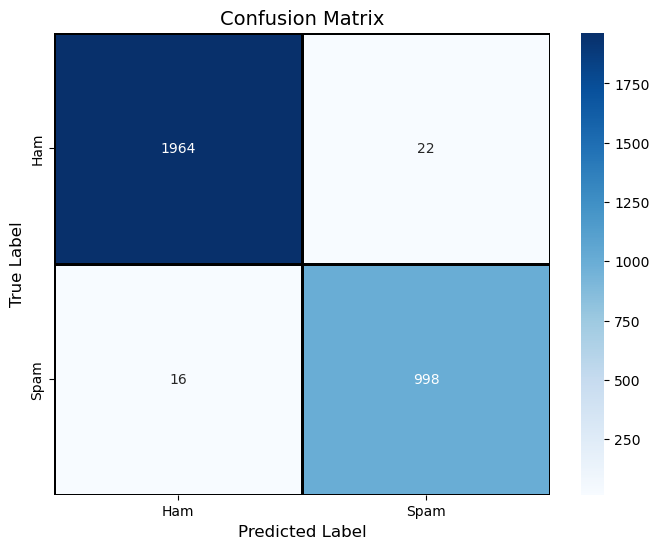

In [56]:
plot_confusion_matrix(test_labels, predicted_labels)

In [63]:
messages = [
    "500 dolar Kazandınız! Hemen linke tıklayın!!!",
    "You won 500 dollars! Just click the link and claim your reward!!!",
    "Merhaba, nasılsın?",
    "Bu çok önemli bir teklif, hemen dönüş yapın.",
    "This is an important offer! please call me back.",
    "Selam, bugün buluşalım mı?",
    "Hi, how are you?",
    "Sifir yazilim bilgisiyle 6 ayda yazilimci olun, sadece 1000 dolar. hemen tıklayın.",
    "Become a software developer in 6 months with zero coding knowledge, only $1000. Click now!"
]
predictions = model.predict(messages)

for message, pred in zip(messages, predictions):
    label = "Spam" if pred > 0.5 else "Ham"
    print(f"Mesaj: {message} → Tahmin: {label} ({pred[0]:.4f})")

1/1 [==============================] - 0s 20ms/step
Mesaj: 500 dolar Kazandınız! Hemen linke tıklayın!!! → Tahmin: Spam (0.6655)
Mesaj: You won 500 dollars! Just click the link and claim your reward!!! → Tahmin: Spam (0.9318)
Mesaj: Merhaba, nasılsın? → Tahmin: Ham (0.0016)
Mesaj: Bu çok önemli bir teklif, hemen dönüş yapın. → Tahmin: Ham (0.0103)
Mesaj: This is an important offer! please call me back. → Tahmin: Ham (0.1455)
Mesaj: Selam, bugün buluşalım mı? → Tahmin: Ham (0.0016)
Mesaj: Hi, how are you? → Tahmin: Ham (0.0012)
Mesaj: Sifir yazilim bilgisiyle 6 ayda yazilimci olun, sadece 1000 dolar. hemen tıklayın. → Tahmin: Spam (0.9958)
Mesaj: Become a software developer in 6 months with zero coding knowledge, only $1000. Click now! → Tahmin: Spam (0.7976)


**We have achieved a good non-seen & custom defined message spam classification, it can even detect the last example :)**

# 🏆 Conclusion & Future Work  

###  **Final Model Selection**  
After evaluating multiple approaches, **pretrained transformer models** (**XLM-RoBERTa, BERT Multilingual, and DistilBERT Multilingual**) achieved the best results. However, due to the **large checkpoint sizes (2-3GB per model)**, they were not used in deployment.  

Instead, the **TensorFlow-based DNN model** was selected as the **solution model** due to its:  
**Lightweight architecture** for easy deployment.  
**Competitive performance** compared to transformer models.  
**Efficient processing** while maintaining strong classification accuracy.  

The main problem with it, it works perfect if the message contains vectorized artifacts. otherwise it can struggle a bit. So using a more advanced DL arch like transformers block & LSTMs with a more comprehensive dataset.

---

##  **Further Work & Improvements**  

🔹 **Optimize Feature Engineering**  
- Experiment with **different text embeddings** (e.g., FastText, Word2Vec).  
- Fine-tune **vectorization parameters** for better text representation.  

🔹 **Enhance Model Performance**  
- Explore **hybrid models** combining **traditional ML (SVM, CatBoost) and DNNs**.  
- Implement **knowledge distillation** to reduce transformer model size for practical use.  

🔹 **MLOps & Deployment**  
- Integrate **MLflow** for model tracking and versioning.  
- Deploy models using **TF Serving**

This project successfully demonstrated the **impact of model selection, preprocessing techniques, and hyperparameter tuning** in spam detection. The next steps involve **refining the model, optimizing deployment, and exploring real-world applications**. 
